In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext lab_black

# This file suits to the default dataframe that is given by super_pipe. The name of the columns are hardcoded and should be changed manually in case you want to evaluate your results with a super_pipe different from the one in `/export/home/cse200093/Jacques_Bio/super_pipe/py_files`

In [36]:
import pandas as pd
import re
from os.path import isfile, isdir, join, basename
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

# Import unit registry for found-gold comparison
from edsnlp.pipelines.misc.measurements.patterns import units_config
from edsnlp.pipelines.misc.measurements.measurements import (
    SimpleMeasurement,
    UnitRegistry,
)
import spacy

import sys

sys.path.insert(1, "/export/home/cse200093/Jacques_Bio/super_pipe/py_files/utils")
from extract_pandas_from_brat import extract_pandas

# Import measurements extractor
sys.path.insert(1, "/export/home/cse200093/Jacques_Bio/super_pipe/py_files/")
import extract_measurements_from_brat

UNIT_REGISTRY = UnitRegistry(units_config)

GOLD_BRAT_DIR = (
    "/export/home/cse200093/Jacques_Bio/data_bio/gold_std_NLP_diabeto/annotation"
)
PRED_BRAT_DIR = (
    "/export/home/cse200093/Jacques_Bio/data_bio/gold_std_NLP_diabeto/pred_ner"
)
LABELS_TO_KEEP = ["BIO"]

RES_DIR = "/export/home/cse200093/Jacques_Bio/data_bio/gold_std_NLP_diabeto/res.json"

TO_BE_MATCHED = {
    "lupus_erythemateux_dissemine": {
        "CIM10": ["M320", "M321", "M328", "M329"],
        "CUI_per_section": {
            "all": {
                "Facteur anti-nucléaire": [
                    "C0587178",
                    "C1271804",
                    "C1273464",
                    "C1277811",
                ],
                "Anti-DNA natif": ["C1262035", "C0282056"],
                "Anti-Sm": ["C0201357"],
            },
            "examens complémentaires": {
                "Hémoglobine": ["C0518015"],
                "CRP": ["C0201657"],
                "Créatininémie": ["C0201975"],
                "DFG": ["C0017654", "C2733005"],
            },
        },
    },
    "syndrome_des_anti-phospholipides": {
        "CIM10": ["D686"],
        "CUI_per_section": {
            "all": {
                "Anti-cardiolipides": ["C0201535", "C0455311"],
                "Anti_phospholipides": ["C0201534"],
                "anti_B2GP1": ["C1295005", "C1303280"],
                "anticoagulant_circulant_lupique": [
                    "C0455328",
                    "C1142517",
                    "C1277823",
                    "C0522828",
                ],
            },
            "examens complémentaires": {
                "INR": ["C0525032"],
                "Hémoglobine": ["C0518015"],
                "CRP": ["C0201657"],
                "Créatininémie": ["C0201975"],
            },
        },
    },
    "sclerodermie_systemique": {
        "CIM10": ["M340", "M341", "M348", "M349"],
        "CUI_per_section": {
            "all": {
                "Anti-RNA pol 3": ["C1295034"],
                "Anti-SCL 70": ["C0523317"],
                "Anti-centromères": ["C0201361"],
            },
            "examens complémentaires": {
                "Hémoglobine": ["C0518015"],
                "CRP": ["C0201657"],
                "Créatininémie": ["C0201975"],
                "DFG": ["C0017654", "C2733005"],
            },
        },
    },
    "maladie_de_takayasu": {
        "CIM10": ["M314"],
        "CUI_per_section": {
            "all": {},
            "examens complémentaires": {
                "Hémoglobine": ["C0518015"],
                "CRP": ["C0201657"],
                "Créatininémie": ["C0201975"],
                "DFG": ["C0017654", "C2733005"],
            },
        },
    },
}

In [37]:
cuis_to_keep = {"gold_label": [], "bio": []}
for disease, disease_data in TO_BE_MATCHED.items():
    for cui_dic in disease_data["CUI_per_section"].values():
        for cui_label, cui_list in cui_dic.items():
            for cui in cui_list:
                if cui not in cuis_to_keep["gold_label"]:
                    cuis_to_keep["gold_label"].append(cui)
                    cuis_to_keep["bio"].append(cui_label)
cuis_to_keep = pd.DataFrame(cuis_to_keep)

In [42]:
# Load annotations

REGEX_CONVERT_SPANS = re.compile("^(\d+).*\s(\d+)$")

# Convert span to list with span_start, span_end. It considers the new lines by adding one character.
def convert_spans(span):
    span_match = REGEX_CONVERT_SPANS.match(span)
    span_start = int(span_match.group(1))
    span_end = int(span_match.group(2))
    return [span_start, span_end]


pred_df = extract_pandas(IN_BRAT_DIR=PRED_BRAT_DIR)
pred_df["span_converted"] = pred_df["span"].apply(convert_spans)
pred_df = pred_df.drop(columns=["span", "ann_id"])
display(pred_df)

,term,label,source,span_converted
0,Lupus érythémateux disséminé,DISO,CRH_6597073009782217758.ann,"[197, 225]"
1,Histoire de la maladie,SECTION_histoire,CRH_6597073009782217758.ann,"[478, 500]"
2,lupus érythémateux disséminé,DISO,CRH_6597073009782217758.ann,"[515, 543]"
3,"polyarthralgiesau niveau des 2 mains, des pieds",DISO,CRH_6597073009782217758.ann,"[574, 621]"
4,AAN,DISO,CRH_6597073009782217758.ann,"[627, 630]"
...,...,...,...,...
21382,Aranesp,Chemical_and_drugs,CRH_217255088325054721.ann,"[5171, 5178]"
21383,80 µg par semaine,dosage,CRH_217255088325054721.ann,"[5179, 5196]"
21384,produits sanguins labiles,Chemical_and_drugs,CRH_217255088325054721.ann,"[5323, 5348]"
21385,produits dérivés du sang,Chemical_and_drugs,CRH_217255088325054721.ann,"[5375, 5399]"


In [43]:
# Load annotations

REGEX_CONVERT_SPANS = re.compile("^(\d+).*\s(\d+)$")

# Convert span to list with span_start, span_end. It considers the new lines by adding one character.
def convert_spans(span):
    span_match = REGEX_CONVERT_SPANS.match(span)
    span_start = int(span_match.group(1))
    span_end = int(span_match.group(2))
    return [span_start, span_end]


gold_df = extract_pandas(IN_BRAT_DIR=GOLD_BRAT_DIR)
annotations_df = gold_df.loc[gold_df["label"] == "AnnotatorNotes"]
annotations_df = annotations_df.rename(
    columns={"term": "annotation", "ann_id": "annotation_id", "span": "ann_id"}
)

gold_df = gold_df.loc[gold_df["label"] != "AnnotatorNotes"]
gold_df["span_converted"] = gold_df["span"].apply(convert_spans)
display(gold_df)
display(annotations_df)

,ann_id,term,label,source,span,span_converted
0,T4,Ig IV,Chemical_and_drugs,CRH_6422236702278476027.ann,205 210,"[205, 210]"
1,T5,hypo gammaglobulinémie,DISO,CRH_6422236702278476027.ann,216 238,"[216, 238]"
2,T6,Hypogamma,DISO,CRH_6422236702278476027.ann,248 257,"[248, 257]"
3,T10,pneumovax,Chemical_and_drugs,CRH_6422236702278476027.ann,367 376,"[367, 376]"
4,T13,influvac tetra,Chemical_and_drugs,CRH_6422236702278476027.ann,413 427,"[413, 427]"
...,...,...,...,...,...,...
27996,T518,sang,BIO_milieu,CRH_1986612158944326825.ann,7244 7248,"[7244, 7248]"
27997,T519,50mg,Chemical_and_drugs,CRH_1986612158944326825.ann,5858 5862,"[5858, 5862]"
27998,T81,BCR-ABL,BIO,CRH_1986612158944326825.ann,3277 3284,"[3277, 3284]"
27999,T101,BCR-ABL le 16/03 sur sang positif,BIO_comp,CRH_1986612158944326825.ann,3277 3310,"[3277, 3310]"


,annotation_id,annotation,label,source,ann_id
4457,#1,C0201720,AnnotatorNotes,CRH_-1203468945324601250.ann,T479
4458,#2,C0023901,AnnotatorNotes,CRH_-1203468945324601250.ann,T309
4459,#3,C1277709,AnnotatorNotes,CRH_-1203468945324601250.ann,T28
4460,#4,C0201973,AnnotatorNotes,CRH_-1203468945324601250.ann,T197
4461,#5,C0201973,AnnotatorNotes,CRH_-1203468945324601250.ann,T481
...,...,...,...,...,...
27984,#204,A12BA01,AnnotatorNotes,CRH_1986612158944326825.ann,T99
27985,#205,C2733507,AnnotatorNotes,CRH_1986612158944326825.ann,T509
27986,#206,H02AB07,AnnotatorNotes,CRH_1986612158944326825.ann,T94
27987,#207,H02AB09,AnnotatorNotes,CRH_1986612158944326825.ann,T146


In [44]:
# Merge BIO and annotations, keep them only
gold_df = pd.merge(
    gold_df.loc[gold_df["label"].isin(LABELS_TO_KEEP)][
        ["ann_id", "term", "source", "span_converted", "label"]
    ],
    annotations_df[["ann_id", "annotation", "source"]],
    how="left",
    on=["source", "ann_id"],
).drop(columns="ann_id")
gold_df = gold_df.loc[~gold_df["annotation"].isna()]
# # Only keep the BIO with a measurement. They must have a "_" which
# # is used to separate the CUI of the measurement
# gold_df = gold_df.loc[gold_df["annotation"].str.contains("_")].reset_index(drop=True)
gold_df = gold_df.rename(columns={"label": "label_type"})
gold_df

,term,source,span_converted,label_type,annotation
1053,BH,CRH_-1203468945324601250.ann,"[936, 938]",BIO,C0023901
1054,anti SSA,CRH_-1203468945324601250.ann,"[2007, 2015]",BIO,O:C1168447
1055,FAN,CRH_-1203468945324601250.ann,"[3916, 3919]",BIO,C0587178
1056,SSB,CRH_-1203468945324601250.ann,"[3945, 3948]",BIO,O:C5190264
1057,pANCA,CRH_-1203468945324601250.ann,"[3959, 3964]",BIO,C0134596
...,...,...,...,...,...
6075,CD3+CD4+,CRH_1986612158944326825.ann,"[11639, 11647]",BIO,C1294977
6076,CD3+CD8+,CRH_1986612158944326825.ann,"[11672, 11680]",BIO,C1531750
6077,CD3+CD8+,CRH_1986612158944326825.ann,"[11703, 11711]",BIO,C1531750
6078,Myélogramme,CRH_1986612158944326825.ann,"[3070, 3081]",BIO,C0398523


In [45]:
gold_df["gold_label"] = (
    gold_df["annotation"]
    .mask(
        gold_df["annotation"].str.contains(":"),
        gold_df["annotation"].str.split(":").str.get(1),
    )
    .mask(
        gold_df["annotation"].str.contains("_"),
        gold_df["annotation"].str.split("_").str.get(0),
    )
)
# gold_df = gold_df.merge(cuis_to_keep, on="gold_label")
gold_df

,term,source,span_converted,label_type,annotation,gold_label
1053,BH,CRH_-1203468945324601250.ann,"[936, 938]",BIO,C0023901,C0023901
1054,anti SSA,CRH_-1203468945324601250.ann,"[2007, 2015]",BIO,O:C1168447,C1168447
1055,FAN,CRH_-1203468945324601250.ann,"[3916, 3919]",BIO,C0587178,C0587178
1056,SSB,CRH_-1203468945324601250.ann,"[3945, 3948]",BIO,O:C5190264,C5190264
1057,pANCA,CRH_-1203468945324601250.ann,"[3959, 3964]",BIO,C0134596,C0134596
...,...,...,...,...,...,...
6075,CD3+CD4+,CRH_1986612158944326825.ann,"[11639, 11647]",BIO,C1294977,C1294977
6076,CD3+CD8+,CRH_1986612158944326825.ann,"[11672, 11680]",BIO,C1531750,C1531750
6077,CD3+CD8+,CRH_1986612158944326825.ann,"[11703, 11711]",BIO,C1531750,C1531750
6078,Myélogramme,CRH_1986612158944326825.ann,"[3070, 3081]",BIO,C0398523,C0398523


In [46]:
# Load results from super_pipe and format It
# To keep BIOs instead of BIO_comp

res_df = pd.read_json(RES_DIR)


def retrieve_span_of_terms_linked_to_measurement(
    term, term_linked_to_measurement, term_span
):
    return [
        term_span[0] + term.find(term_linked_to_measurement[0]),
        term_span[0]
        + term.find(term_linked_to_measurement[0])
        + len(term_linked_to_measurement),
    ]


res_df["span_converted"] = res_df.apply(
    lambda row: retrieve_span_of_terms_linked_to_measurement(
        row["term"], row["terms_linked_to_measurement"], row["span_converted"]
    ),
    axis=1,
)

res_df = res_df[
    [
        "terms_linked_to_measurement",
        "term",
        "source",
        "span_converted",
        "label",
        "found",
    ]
].rename(columns={"term": "full_term", "terms_linked_to_measurement": "term"})
res_df = res_df.merge(gold_df[["source"]].drop_duplicates(), on="source")
res_df["detected_span"] = (
    res_df["span_converted"].str.get(0).astype(str)
    + "_"
    + res_df["span_converted"].str.get(1).astype(str)
)
res_df["detected_term"] = res_df["term"]
res_df["span_res"] = res_df["span_converted"]
# res_df = res_df.explode("label")
# res_df = res_df.merge(cuis_to_keep.rename(columns={"gold_label": "label"}), on="label")
# res_df["detected_bio"] = res_df["bio"]
res_df

,term,full_term,source,span_converted,label,found,detected_span,detected_term,span_res
0,Leucocytes,Leucocytes ¦x10*9/l ¦9.6 ¦ ¦ ¦4.0-10.0,CRH_1986612158944326825.ann,"[9775, 9785]",[C0023508],[= 9600000000.0 per_l],9775_9785,Leucocytes,"[9775, 9785]"
1,Hémoglobine,Hémoglobine ¦g/dl ¦11.4 - ¦ ¦ ¦12-17,CRH_1986612158944326825.ann,"[9814, 9825]",[C0518015],[= 11.4 g_per_dl],9814_9825,Hémoglobine,"[9814, 9825]"
2,Plaquettes,Plaquettes ¦x10*9/l ¦64 - ¦ ¦ ¦150-450,CRH_1986612158944326825.ann,"[9851, 9861]",[C0032181],[= 64000000000.0 per_l],9851_9861,Plaquettes,"[9851, 9861]"
3,Polynucléaires ne…,Polynucléaires ne…¹ ¦x10*9/l ¦2.1 ¦ ¦ ¦1.5-7.0,CRH_1986612158944326825.ann,"[9907, 9925]",[C0857490],[= 2100000000.0 per_l],9907_9925,Polynucléaires ne…,"[9907, 9925]"
4,Polynucléaires éo…,Polynucléaires éo…² ¦x10*9/l ¦0.5 ¦ ¦ ¦0.0-0.5,CRH_1986612158944326825.ann,"[9954, 9972]",[C1271714],[= 500000000.0 per_l],9954_9972,Polynucléaires éo…,"[9954, 9972]"
...,...,...,...,...,...,...,...,...,...
635,Troponine Ic,Troponine Ic (TnIH) ¦ng/L ¦4 ¦<34,CRH_-1203468945324601250.ann,"[7971, 7983]",[C1141947],[= 4.0 ng_per_l],7971_7983,Troponine Ic,"[7971, 7983]"
636,BNP,BNP ¦ng/L ¦18 ¦<100,CRH_-1203468945324601250.ann,"[8005, 8008]",[C1095989],[= 18.0 ng_per_l],8005_8008,BNP,"[8005, 8008]"
637,Fer,Fer ¦µmol/L ¦8.8 - ¦9.0-30.0,CRH_-1203468945324601250.ann,"[8039, 8042]",[C0337439],[= 8.8 µmol_per_l],8039_8042,Fer,"[8039, 8042]"
638,Transferrine,Transferrine ¦g/L ¦2.46 ¦2.00-3.50,CRH_-1203468945324601250.ann,"[8068, 8080]",[C0202105],[= 2.46 g_per_l],8068_8080,Transferrine,"[8068, 8080]"


In [47]:
pred_df

,term,label,source,span_converted
0,Lupus érythémateux disséminé,DISO,CRH_6597073009782217758.ann,"[197, 225]"
1,Histoire de la maladie,SECTION_histoire,CRH_6597073009782217758.ann,"[478, 500]"
2,lupus érythémateux disséminé,DISO,CRH_6597073009782217758.ann,"[515, 543]"
3,"polyarthralgiesau niveau des 2 mains, des pieds",DISO,CRH_6597073009782217758.ann,"[574, 621]"
4,AAN,DISO,CRH_6597073009782217758.ann,"[627, 630]"
...,...,...,...,...
21382,Aranesp,Chemical_and_drugs,CRH_217255088325054721.ann,"[5171, 5178]"
21383,80 µg par semaine,dosage,CRH_217255088325054721.ann,"[5179, 5196]"
21384,produits sanguins labiles,Chemical_and_drugs,CRH_217255088325054721.ann,"[5323, 5348]"
21385,produits dérivés du sang,Chemical_and_drugs,CRH_217255088325054721.ann,"[5375, 5399]"


In [71]:
# Link each found BIO to one annoytated BIO


def is_overlapping(a, b):
    # Return true if a segment is overlapping b
    # else False
    return min(a[1], b[1]) > max(a[0], b[0])


detected_res = {"detected_label": [], "detected_span": []}
pred_res = {"pred_label": [], "pred_span": [], "pred_term": []}
for _, row in gold_df.iterrows():
    detected_label_part = None
    detected_span_part = []
    pred_label_part = []
    pred_span_part = []
    pred_term_part = []
    for _, (detected_span, detected_label) in res_df.loc[
        res_df["source"] == row["source"]
    ][["span_converted", "label"]].iterrows():
        if is_overlapping(detected_span, row["span_converted"]):
            detected_label_part = detected_label
            detected_span_part += detected_span
    for _, (pred_span, pred_label, pred_term) in pred_df.loc[
        pred_df["source"] == row["source"]
    ][["span_converted", "label", "term"]].iterrows():
        if is_overlapping(pred_span, row["span_converted"]):
            pred_label_part.append(pred_label)
            pred_span_part += pred_span
            pred_term_part.append(pred_term)
    detected_res["detected_label"].append(detected_label_part)
    detected_res["detected_span"].append(detected_span_part)
    pred_res["pred_label"].append(pred_label_part)
    pred_res["pred_span"].append(pred_span_part)
    pred_res["pred_term"].append(pred_term_part)
final_df = (
    gold_df.reset_index(drop=True)
    .join(pd.DataFrame(detected_res))
    .join(pd.DataFrame(pred_res))
)
final_df["detected_span"] = (
    final_df["detected_span"].str.get(0).astype("Int64").astype(str)
    + "_"
    + final_df["detected_span"].str.get(1).astype("Int64").astype(str)
)

final_df = final_df.merge(
    res_df[
        [
            "source",
            "detected_term",
            "detected_span",
            "label",
            "span_res",
            # "detected_bio",
            "full_term",
        ]
    ],
    on=["source", "detected_span"],
    how="outer",
)
final_df["detected_label"] = final_df["detected_label"].mask(
    final_df["detected_label"].isna(), final_df["label"]
)
final_df = final_df.drop(columns=["detected_span", "label"])
final_df = final_df.rename(columns={"span_res": "detected_span"})
final_df["TP"] = final_df.apply(
    lambda row: row["gold_label"] in row["detected_label"]
    if isinstance(row["detected_label"], list)
    else False,
    axis=1,
)
final_df["FP"] = final_df.apply(
    lambda row: row["gold_label"] not in row["detected_label"]
    if isinstance(row["detected_label"], list)
    else False,
    axis=1,
)
# final_df["TP"] = ~(final_df["detected_label"].isna()) & (
#     final_df["bio"] == final_df["detected_bio"]
# )
# final_df["FP"] = ~(final_df["detected_label"].isna()) & ~(
#     final_df["bio"] == final_df["detected_bio"]
# )
final_df["FN"] = final_df["detected_label"].isna()
final_df["not_pred"] = (~final_df.gold_label.isna()) & (
    final_df.pred_label.str.len() == 0
)
final_df = final_df[
    ~(~final_df["detected_label"].isna() & final_df["gold_label"].isna())
]
final_df

,term,source,span_converted,label_type,annotation,gold_label,detected_label,pred_label,pred_span,pred_term,detected_term,detected_span,full_term,TP,FP,FN,not_pred
0,BH,CRH_-1203468945324601250.ann,"[936, 938]",BIO,C0023901,C0023901,NaN,[DISO],"[936, 945]",[BH normal],NaN,NaN,NaN,False,False,True,False
1,anti SSA,CRH_-1203468945324601250.ann,"[2007, 2015]",BIO,O:C1168447,C1168447,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True
2,FAN,CRH_-1203468945324601250.ann,"[3916, 3919]",BIO,C0587178,C0587178,NaN,"[BIO, DISO]","[3916, 3919, 3916, 3928]","[FAN, FAN négatifs]",NaN,NaN,NaN,False,False,True,False
3,SSB,CRH_-1203468945324601250.ann,"[3945, 3948]",BIO,O:C5190264,C5190264,NaN,"[BIO, DISO]","[3930, 3948, 3930, 3957]","[Ac anti SSA et SSB, Ac anti SSA et SSB négatifs]",NaN,NaN,NaN,False,False,True,False
4,Ac anti SSA,CRH_-1203468945324601250.ann,"[3930, 3941]",BIO,O:C1168447,C1168447,NaN,"[BIO, DISO]","[3930, 3948, 3930, 3957]","[Ac anti SSA et SSB, Ac anti SSA et SSB négatifs]",NaN,NaN,NaN,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,CD3+,CRH_1986612158944326825.ann,"[11576, 11580]",BIO,C1277786,C1277786,[C1277786],"[BIO, BIO_comp]","[11576, 11580, 11576, 11607]","[CD3+, CD3+ ¦/µl ¦ ¦ ¦4478 + ¦807-1844]",CD3+,"[11576, 11580]",CD3+ ¦/µl ¦ ¦ ¦4478 + ¦807-1844,True,False,False,False
792,CD3+CD4+,CRH_1986612158944326825.ann,"[11608, 11616]",BIO,C1294977,C1294977,[C1294977],"[BIO, BIO_comp]","[11608, 11616, 11608, 11638]","[CD3+CD4+, CD3+CD4+ ¦% ¦ ¦ ¦16.6 - ¦34-62]",CD3+CD4+,"[11608, 11616]",CD3+CD4+ ¦% ¦ ¦ ¦16.6 - ¦34-62,True,False,False,False
793,CD3+CD4+,CRH_1986612158944326825.ann,"[11639, 11647]",BIO,C1294977,C1294977,[C1294977],"[BIO, BIO_comp]","[11639, 11647, 11639, 11671]","[CD3+CD4+, CD3+CD4+ ¦/µl ¦ ¦ ¦808 ¦460-1232]",CD3+CD4+,"[11639, 11647]",CD3+CD4+ ¦/µl ¦ ¦ ¦808 ¦460-1232,True,False,False,False
794,CD3+CD8+,CRH_1986612158944326825.ann,"[11672, 11680]",BIO,C1531750,C1531750,[C1531750],"[BIO, BIO_comp]","[11672, 11680, 11672, 11702]","[CD3+CD8+, CD3+CD8+ ¦% ¦ ¦ ¦64.0 + ¦14-42]",CD3+CD8+,"[11672, 11680]",CD3+CD8+ ¦% ¦ ¦ ¦64.0 + ¦14-42,True,False,False,False


In [126]:
print(f"TP: {final_df.TP.sum()} ({final_df.TP.sum()/len(final_df) * 100:.2f} %)")
final_df[final_df.TP].sample(10)

TP: 327 (41.08 %)


,term,source,span_converted,label_type,annotation,gold_label,detected_label,pred_label,pred_span,pred_term,detected_term,detected_span,full_term,TP,FP,FN,not_pred
612,Alpha 2 globulines,CRH_-4679685873945031550.ann,"[24792, 24810]",BIO,C0430070,C0430070,[C0430070],"[BIO, BIO_comp]","[24792, 24810, 24792, 24863]","[Alpha 2 globulines, Alpha 2 globulines ...",Alpha 2 globulines,"[24792, 24810]",Alpha 2 globulines 5.5 ...,True,False,False,False
125,Créatinine,CRH_-6070744700027231896.ann,"[4902, 4912]",BIO,C0201975_9.6mmol/L,C0201975,[C0201975],"[BIO, BIO_comp]","[4902, 4912, 4902, 4925]","[Créatinine, Créatinine ¦mmol/L ¦9.6]",Créatinine,"[4902, 4912]",Créatinine ¦mmol/L ¦9.6,True,False,False,False
540,Facteur rhumatoide,CRH_-3683527531913451370.ann,"[12122, 12140]",BIO,C0201660,C0201660,[C0201660],"[BIO, BIO_comp]","[12122, 12140, 12122, 12160]","[Facteur rhumatoide, Facteur rhumatoide ¦UI/mL...",Facteur rhumatoide,"[12122, 12140]",Facteur rhumatoide ¦UI/mL ¦<10 ¦ ¦0-14,True,False,False,False
578,Anti-Scl70,CRH_-4679685873945031550.ann,"[27672, 27682]",BIO,C0523317,C0523317,[C0523317],"[BIO, DISO, BIO_comp]","[27672, 27682, 27672, 27717, 27672, 27717]","[Anti-Scl70, Anti-Scl70 ...",Anti-Scl70,"[27672, 27682]",Anti-Scl70 Négatif,True,False,False,False
461,CCMH,CRH_-271437703139108726.ann,"[6513, 6517]",BIO,C0474535,C0474535,[C0474535],"[BIO, BIO_comp]","[6513, 6517, 6513, 6540]","[CCMH, CCMH ¦g/dL ¦32.6 ¦32.0-35.0]",CCMH,"[6513, 6517]",CCMH ¦g/dL ¦32.6 ¦32.0-35.0,True,False,False,False
596,Protéines/Créatinine,CRH_-4679685873945031550.ann,"[22523, 22543]",BIO,C0428627,C0428627,[C0428627],"[BIO, BIO_comp]","[22523, 22543, 22523, 22598]","[Protéines/Créatinine, Protéines/Créatinine ...",Protéines/Créatinine,"[22523, 22543]",Protéines/Créatinine 10.5 ...,True,False,False,False
599,Triglycérides,CRH_-4679685873945031550.ann,"[22913, 22926]",BIO,C0202236,C0202236,[C0202236],"[BIO, BIO_comp]","[22913, 22926, 22913, 22987]","[Triglycérides, Triglycérides ...",Triglycérides,"[22913, 22926]",Triglycérides 1.07 ...,True,False,False,False
586,ALAT,CRH_-4679685873945031550.ann,"[20985, 20989]",BIO,C0201836,C0201836,[C0201836],"[BIO, BIO_comp]","[20985, 20989, 20985, 21056]","[ALAT, ALAT 1...",ALAT,"[20985, 20989]",ALAT 13 ...,True,False,False,False
131,TSH,CRH_-6070744700027231896.ann,"[4676, 4679]",BIO,C0202230_3.56mU/L,C0202230,[C0202230],"[BIO, BIO_comp]","[4676, 4679, 4676, 4702]","[TSH, TSH ¦mU/L ¦3.56 ¦0.27-4.20]",TSH,"[4676, 4679]",TSH ¦mU/L ¦3.56 ¦0.27-4.20,True,False,False,False
494,Fer,CRH_-271437703139108726.ann,"[7594, 7597]",BIO,C0337439,C0337439,[C0337439],"[BIO, BIO_comp]","[7594, 7597, 7594, 7616]","[Fer, Fer ¦µmol/L ¦7 - ¦9-30]",Fer,"[7594, 7597]",Fer ¦µmol/L ¦7 - ¦9-30,True,False,False,False


In [132]:
print(f"FP: {final_df.FP.sum()} ({final_df.FP.sum()/len(final_df) * 100:.2f} %)")
final_df[final_df.FP].sample(10)

FP: 130 (16.33 %)


,term,source,span_converted,label_type,annotation,gold_label,detected_label,pred_label,pred_span,pred_term,detected_term,detected_span,full_term,TP,FP,FN,not_pred
618,CD3+,CRH_-4679685873945031550.ann,"[25580, 25584]",BIO,C1277790,C1277790,[C0201157],[BIO_comp],"[25580, 25640]",[CD3+ 1197 ...,CD3+ 1197 ...,"[25580, 25640]",CD3+ 1197 ...,False,True,False,False
352,AMH,CRH_-3491127894659086898.ann,"[6428, 6431]",BIO,C4041018,C4041018,[C1266197],"[BIO, BIO_comp]","[6428, 6431, 6428, 6445]","[AMH, AMH ¦ng/mL ¦<0.02]",AMH,"[6428, 6431]",AMH ¦ng/mL ¦<0.02,False,True,False,False
306,Glycémie,CRH_-2953685622539109544.ann,"[4454, 4462]",BIO,C0337438,C0337438,[C0392201],"[BIO, BIO_comp]","[4454, 4462, 4454, 4472]","[Glycémie, Glycémie: 0.77 g/l]",Glycémie,"[4454, 4462]",Glycémie: 0.77 g/l,False,True,False,False
789,Polynucléaires éo…,CRH_1986612158944326825.ann,"[9954, 9972]",BIO,C0200638,C0200638,[C1271714],"[BIO, BIO_comp]","[9954, 9972, 9954, 10000]","[Polynucléaires éo…, Polynucléaires éo…² ¦x10*...",Polynucléaires éo…,"[9954, 9972]",Polynucléaires éo…² ¦x10*9/l ¦0.5 ¦ ¦ ¦0.0-0.5,False,True,False,False
679,Polynucléaires ne…,CRH_-8838885096796400155.ann,"[5050, 5068]",BIO,C0200633_1.91x10^9/L,C0200633,[C0857490],"[BIO, BIO_comp]","[5050, 5068, 5050, 5091]","[Polynucléaires ne…, Polynucléaires ne…1 ¦x10*...",Polynucléaires ne…,"[5050, 5068]",Polynucléaires ne…1 ¦x10*9/L ¦1.91 ¦1.5-7,False,True,False,False
538,Gamma globulines,CRH_-3683527531913451370.ann,"[11927, 11943]",BIO,C0430072,C0430072,[C0428539],"[BIO, BIO_comp]","[11927, 11943, 11927, 11965]","[Gamma globulines, Gamma globulines ¦% ¦17.0 ¦...",Gamma globulines,"[11927, 11943]",Gamma globulines ¦% ¦17.0 ¦ ¦11.1-18.8,False,True,False,False
381,Anti-thyropéroxydase,CRH_-3491127894659086898.ann,"[7160, 7180]",BIO,C5565034,C5565034,[C1295041],"[BIO, BIO_comp]","[7160, 7180, 7160, 7190]","[Anti-thyropéroxydase, Anti-thyropéroxydase¦UI...",Anti-thyropéroxydase,"[7160, 7180]",Anti-thyropéroxydase¦UI/mL ¦<1,False,True,False,False
275,Osmolarité calculée,CRH_-3331052020138721210.ann,"[4672, 4691]",BIO,C0201804,C0201804,[C0202150],"[BIO, BIO_comp]","[4672, 4691, 4672, 4716]","[Osmolarité calculée, Osmolarité calculée ¦mOs...",Osmolarité calculée,"[4672, 4691]",Osmolarité calculée ¦mOsmol/L¦281 ¦ ¦270-290,False,True,False,False
731,Sodium /24h,CRH_-8838885096796400155.ann,"[4233, 4244]",BIO,C1256585_102mmol/24h,C1256585,[C1278233],"[BIO, BIO_comp]","[4233, 4244, 4233, 4266]","[Sodium /24h, Sodium /24h ¦mmol/24h¦102 ¦40-220]",Sodium /24h,"[4233, 4244]",Sodium /24h ¦mmol/24h¦102 ¦40-220,False,True,False,False
78,Phosphates,CRH_-1203468945324601250.ann,"[7693, 7703]",BIO,C0202178,C0202178,[C0523826],"[BIO, BIO_comp]","[7693, 7703, 7693, 7728]","[Phosphates, Phosphates ¦mmol/L ¦1.10 ¦0.80-1.45]",Phosphates,"[7693, 7703]",Phosphates ¦mmol/L ¦1.10 ¦0.80-1.45,False,True,False,False


In [134]:
print(f"FN: {final_df.FN.sum()} ({final_df.FN.sum()/len(final_df) * 100:.2f} %)")
print(
    f"FN with pred: {(final_df.FN & (~final_df.not_pred)).sum()} ({(final_df.FN & (~final_df.not_pred)).sum()/len(final_df) * 100:.2f} %)"
)
final_df[final_df.FN & (~final_df.not_pred)].sample(10)

FN: 339 (42.59 %)
FN with pred: 228 (28.64 %)


,term,source,span_converted,label_type,annotation,gold_label,detected_label,pred_label,pred_span,pred_term,detected_term,detected_span,full_term,TP,FP,FN,not_pred
657,serologies HBV,CRH_-8838885096796400155.ann,"[7234, 7248]",BIO,C1278302,C1278302,NaN,[BIO],"[7234, 7248]",[serologies HBV],NaN,NaN,NaN,False,False,True,False
297,"Sérologies VIH, VHB",CRH_-2953685622539109544.ann,"[1444, 1463]",BIO,C1278302,C1278302,NaN,[DISO],"[1460, 1463]",[VHB],NaN,NaN,NaN,False,False,True,False
660,HbA1c,CRH_-8838885096796400155.ann,"[6180, 6185]",BIO,C0202054_8.6%,C0202054,NaN,[BIO],"[6180, 6185]",[HbA1c],NaN,NaN,NaN,False,False,True,False
253,CV,CRH_-3331052020138721210.ann,"[857, 859]",BIO,C1261478,C1261478,NaN,[DISO],"[857, 872]",[CV indétectable],NaN,NaN,NaN,False,False,True,False
101,LDL cholestérol,CRH_-6070744700027231896.ann,"[6583, 6598]",BIO,C0202117_1.06g/l,C0202117,NaN,[BIO],"[6583, 6598]",[LDL cholestérol],NaN,NaN,NaN,False,False,True,False
439,Microalbumine/Cré…,CRH_-271437703139108726.ann,"[7892, 7910]",BIO,C0584615,C0584615,NaN,[BIO],"[7892, 7909]",[Microalbumine/Cré],NaN,NaN,NaN,False,False,True,False
302,hyperéosinophilie,CRH_-2953685622539109544.ann,"[1254, 1271]",BIO,C0200638,C0200638,NaN,"[DISO, BIO]","[1254, 1271, 1254, 1271]","[hyperéosinophilie, hyperéosinophilie]",NaN,NaN,NaN,False,False,True,False
407,VHC : sérologie,CRH_-4088550345923307899.ann,"[4365, 4380]",BIO,C0201487_P,C0201487,NaN,"[DISO, DISO]","[4365, 4368, 4371, 4382]","[VHC, sérologie +]",NaN,NaN,NaN,False,False,True,False
301,VHC,CRH_-2953685622539109544.ann,"[1467, 1470]",BIO,C0201487,C0201487,NaN,[DISO],"[1467, 1480]",[VHC négatives],NaN,NaN,NaN,False,False,True,False
363,Anti-Thyroglobuline,CRH_-3491127894659086898.ann,"[7328, 7347]",BIO,C0201512,C0201512,NaN,[BIO],"[7328, 7347]",[Anti-Thyroglobuline],NaN,NaN,NaN,False,False,True,False


In [137]:
pred_diso_bio = (
    final_df["pred_label"].apply(
        lambda x: ("DISO" in x) and ("BIO" in x) and ("BIO_comp" not in x)
    )
).sum()
print(
    f"FN with pred [BIO, DISO]: {pred_diso_bio} ({pred_diso_bio/len(final_df) * 100:.2f} %)"
)
final_df[
    final_df["pred_label"].apply(
        lambda x: ("DISO" in x) and ("BIO" in x) and ("BIO_comp" not in x)
    )
].sample(10)

FN with pred [BIO, DISO]: 58 (7.29 %)


,term,source,span_converted,label_type,annotation,gold_label,detected_label,pred_label,pred_span,pred_term,detected_term,detected_span,full_term,TP,FP,FN,not_pred
188,anti-SSA,CRH_-3185681183879057337.ann,"[762, 770]",BIO,C0201362_P,C0201362,NaN,"[BIO, DISO]","[762, 770, 762, 779]","[anti-SSA, anti-SSA positifs]",NaN,NaN,NaN,False,False,True,False
207,anticentromère,CRH_-3185681183879057337.ann,"[11099, 11113]",BIO,C0201361_P,C0201361,NaN,"[BIO, DISO]","[11099, 11113, 11099, 11148]","[anticentromère, anticentromère les te du bila...",NaN,NaN,NaN,False,False,True,False
228,Ac anti-annexine V,CRH_-1130604515042545089.ann,"[3220, 3238]",BIO,NaN,NaN,NaN,"[DISO, BIO]","[3160, 3254, 3220, 3236]","[anti-B2GPI, anti-phosphatidyl ethanolamine et...",NaN,NaN,NaN,False,False,True,False
644,Ac anti-HBc,CRH_-1702962569014770695.ann,"[2887, 2898]",BIO,C0201480,C0201480,NaN,"[BIO, DISO]","[2887, 2898, 2887, 2900]","[Ac anti-HBc, Ac anti-HBc -]",NaN,NaN,NaN,False,False,True,False
550,Facteur rhumatoide,CRH_-4679685873945031550.ann,"[29033, 29051]",BIO,C0201660,C0201660,NaN,"[DISO, BIO]","[29033, 29051, 29033, 29051]","[Facteur rhumatoide, Facteur rhumatoide]",NaN,NaN,NaN,False,False,True,False
2,FAN,CRH_-1203468945324601250.ann,"[3916, 3919]",BIO,C0587178,C0587178,NaN,"[BIO, DISO]","[3916, 3919, 3916, 3928]","[FAN, FAN négatifs]",NaN,NaN,NaN,False,False,True,False
220,anti-DNA,CRH_-1130604515042545089.ann,"[1813, 1821]",BIO,C0282056,C0282056,NaN,"[BIO, DISO]","[1813, 1821, 1813, 1835]","[anti-DNA, anti-DNA à taux élevés]",NaN,NaN,NaN,False,False,True,False
643,Ac anti-HbS,CRH_-1702962569014770695.ann,"[2872, 2883]",BIO,C0201478,C0201478,NaN,"[BIO, DISO]","[2872, 2883, 2872, 2885]","[Ac anti-HbS, Ac anti-HbS -]",NaN,NaN,NaN,False,False,True,False
194,anti scl70,CRH_-3185681183879057337.ann,"[4050, 4060]",BIO,C0523317_P,C0523317,NaN,"[DISO, BIO]","[3989, 4060, 4050, 4060]",[Sclérodermie systémique cutanée limitée à Ant...,NaN,NaN,NaN,False,False,True,False
37,CPK,CRH_-1203468945324601250.ann,"[1176, 1179]",BIO,C0201973,C0201973,NaN,"[BIO, DISO]","[1176, 1179, 1176, 1187]","[CPK, CPK normaux]",NaN,NaN,NaN,False,False,True,False


In [139]:
print(
    f"FP with no pred: {(final_df.FN & (final_df.not_pred)).sum()} ({(final_df.FN & (final_df.not_pred)).sum()/len(final_df) * 100:.2f} %)"
)
final_df[final_df.FN & (final_df.not_pred)].sample(10)

FP with no pred: 111 (13.94 %)


,term,source,span_converted,label_type,annotation,gold_label,detected_label,pred_label,pred_span,pred_term,detected_term,detected_span,full_term,TP,FP,FN,not_pred
320,Protides,CRH_-3247703852780693345.ann,"[6569, 6577]",BIO,C0202202,C0202202,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True
324,dosage de POSACONAZOLE,CRH_-3247703852780693345.ann,"[6819, 6841]",BIO,C5201961,C5201961,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True
392,alphafoetoprotéine,CRH_-4088550345923307899.ann,"[2656, 2674]",BIO,C0201539_2.32ng/mL,C0201539,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True
448,hypoglycémie,CRH_-271437703139108726.ann,"[2707, 2719]",BIO,C0005803,C0005803,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True
658,bilan hépatique,CRH_-8838885096796400155.ann,"[7213, 7228]",BIO,C0023901,C0023901,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True
210,immunophénotypage,CRH_-3185681183879057337.ann,"[12768, 12785]",BIO,C0587344,C0587344,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True
522,CD4/CD8,CRH_-3683527531913451370.ann,"[4998, 5005]",BIO,C0085115,C0085115,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True
654,EBV,CRH_-1702962569014770695.ann,"[3207, 3210]",BIO,C0851107,C0851107,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True
553,ANTICORPS ANTI-CYTOPLASME DES POLYNUCLEAIRES N...,CRH_-4679685873945031550.ann,"[28558, 28622]",BIO,C0201530,C0201530,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True
170,Zinc,CRH_-1566724254088175452.ann,"[4479, 4483]",BIO,C0373748,C0373748,NaN,[],[],[],NaN,NaN,NaN,False,False,True,True


In [31]:
# Bootstrap for recall, precision and f1score
@lru_cache(max_size=None)
def get_recall_precision_f1score(tp, fp, fn):
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1score = 2 * (recall * precision) / (recall + precision)
    return recall, precision, f1score


recall, precision, f1score = get_recall_precision_f1score(
    final_df.TP.sum(), final_df.TP.sum(), final_df.FN.sum()
)
print(f"Recall : {recall}")
print(f"Precision : {precision}")
print(f"F1 : {f1score}")

Recall : 0.49099099099099097
Precision : 0.7155361050328227
F1 : 0.5823686553873553


In [18]:
metrics = final_df[["TP", "FP", "FN"]]
n_resamples = 100000
part_size = 25
recalls = []
precisions = []
f1scores = []
for i in range(n_resamples):

    part = metrics.sample(frac=1, replace=True)
    tp = part.TP.sum()
    fp = part.FP.sum()
    fn = part.FN.sum()
    recall, precision, f1score = get_recall_precision_f1score(tp, fp, fn)
    recalls.append(recall)
    precisions.append(precision)
    f1scores.append(f1score)

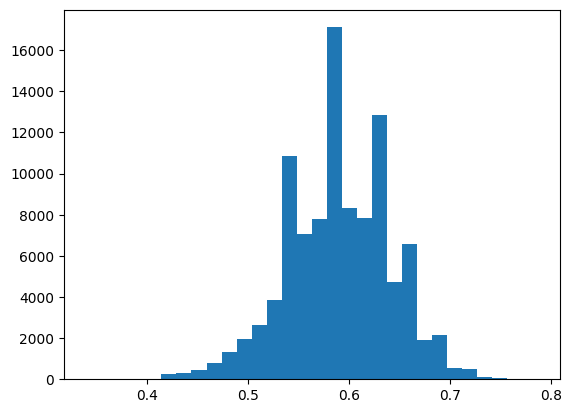

Mean:  0.5901300556810669
Confidence interval:  [0.48275862 0.68656716]


In [19]:
plt.hist(f1scores, bins=30)
plt.show()
print("Mean: ", mean(f1scores))
conf_interval_f1score = np.percentile(f1scores, [2.5, 97.5])
print("Confidence interval: ", conf_interval_f1score)

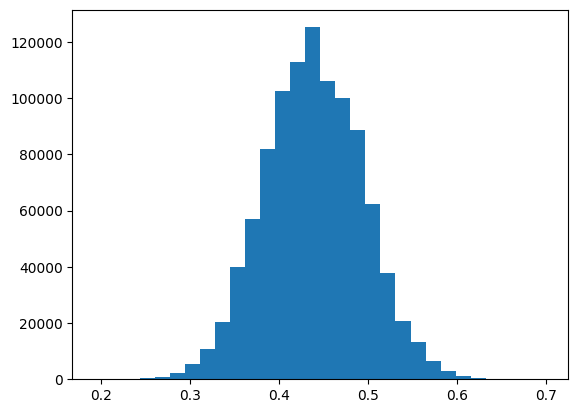

Mean:  0.4389843370992779
Confidence interval:  [0.33333333 0.54761905]


In [188]:
plt.hist(recalls, bins=30)
plt.show()
print("Mean: ", mean(recalls))
conf_interval_recall = np.percentile(recalls, [2.5, 97.5])
print("Confidence interval: ", conf_interval_recall)

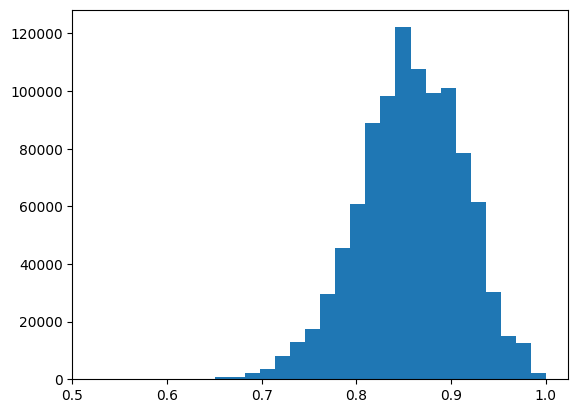

Mean:  0.85716092725413
Confidence interval:  [0.74358974 0.95348837]


In [189]:
plt.hist(precisions, bins=30)
plt.show()
print("Mean: ", mean(precisions))
conf_interval_precision = np.percentile(precisions, [2.5, 97.5])
print("Confidence interval: ", conf_interval_precision)

In [14]:
gold_df["annotation_2"] = gold_df["annotation"].str.split(":").str.get(1)

In [11]:
gold_df

,term,source,span_converted,label,annotation,annotation_2
1053,BH,CRH_-1203468945324601250.ann,"[936, 938]",BIO,C0023901,NaN
1054,anti SSA,CRH_-1203468945324601250.ann,"[2007, 2015]",BIO,O:C1168447,C1168447
1055,FAN,CRH_-1203468945324601250.ann,"[3916, 3919]",BIO,C0587178,NaN
1056,SSB,CRH_-1203468945324601250.ann,"[3945, 3948]",BIO,O:C5190264,C5190264
1057,pANCA,CRH_-1203468945324601250.ann,"[3959, 3964]",BIO,C0134596,NaN
...,...,...,...,...,...,...
6075,CD3+CD4+,CRH_1986612158944326825.ann,"[11639, 11647]",BIO,C1294977,NaN
6076,CD3+CD8+,CRH_1986612158944326825.ann,"[11672, 11680]",BIO,C1531750,NaN
6077,CD3+CD8+,CRH_1986612158944326825.ann,"[11703, 11711]",BIO,C1531750,NaN
6078,Myélogramme,CRH_1986612158944326825.ann,"[3070, 3081]",BIO,C0398523,NaN


In [9]:
gold_df.source.nunique()

21

In [ ]:
# Separate annotation into label + measurement column
gold_df["annotation"] = gold_df["annotation"]
gold_df["found"] = gold_df["found"].apply(
    lambda found: [found] if not isinstance(found, list) else found
)
gold_df

In [6]:
# Separate annotation into label + measurement column
def separate_annotation(annotation):
    if not isinstance(annotation, str):
        return [[], []]
    else:
        return [[item] for item in annotation.split("_")]


gold_df[["label", "found"]] = pd.DataFrame(
    gold_df["annotation"].apply(separate_annotation).tolist()
)
gold_df = gold_df.drop(columns=["annotation"])
gold_df["found"] = gold_df["found"].apply(
    lambda found: [found] if not isinstance(found, list) else found
)
gold_df

,term,source,span_converted,label,found
1053,BH,CRH_-1203468945324601250.ann,"[936, 938]",NaN,[nan]
1054,anti SSA,CRH_-1203468945324601250.ann,"[2007, 2015]",NaN,[nan]
1055,FAN,CRH_-1203468945324601250.ann,"[3916, 3919]",NaN,[nan]
1056,SSB,CRH_-1203468945324601250.ann,"[3945, 3948]",NaN,[nan]
1057,pANCA,CRH_-1203468945324601250.ann,"[3959, 3964]",NaN,[nan]
...,...,...,...,...,...
6075,CD3+CD4+,CRH_1986612158944326825.ann,"[11639, 11647]",NaN,[nan]
6076,CD3+CD8+,CRH_1986612158944326825.ann,"[11672, 11680]",NaN,[nan]
6077,CD3+CD8+,CRH_1986612158944326825.ann,"[11703, 11711]",NaN,[nan]
6078,Myélogramme,CRH_1986612158944326825.ann,"[3070, 3081]",NaN,[nan]


In [87]:
# Load results from super_pipe and format It
# To keep BIOs instead of BIO_comp

res_df = pd.read_json(RES_DIR)


def retrieve_span_of_terms_linked_to_measurement(
    term, term_linked_to_measurement, term_span
):
    return [
        term_span[0] + term.find(term_linked_to_measurement[0]),
        term_span[0]
        + term.find(term_linked_to_measurement[0])
        + len(term_linked_to_measurement),
    ]


res_df["span_converted"] = res_df.apply(
    lambda row: retrieve_span_of_terms_linked_to_measurement(
        row["term"], row["terms_linked_to_measurement"], row["span_converted"]
    ),
    axis=1,
)

res_df = res_df[
    [
        "terms_linked_to_measurement",
        "term",
        "source",
        "span_converted",
        "label",
        "found",
    ]
].rename(columns={"term": "full_term", "terms_linked_to_measurement": "term"})
res_df

,term,full_term,source,span_converted,label,found
0,créatininémie,créatininémie à 77 umol/l,CRH_1969733462691716259.ann,"[4176, 4189]",[C0201975],[= 77.0 nounit]
1,Glucose à jeun,Glucose à jeun ¦mmol/L ¦5.8 + ¦3.9-5.6,CRH_1969733462691716259.ann,"[16227, 16241]",[C0428568],[= 5.8 mmol_per_l]
2,Glucose à jeun,Glucose à jeun ¦g/L ¦1.05 + ¦0.70-1.00,CRH_1969733462691716259.ann,"[16266, 16280]",[C0428568],[= 1.05 g_per_l]
3,Sodium,Sodium ¦mmol/L ¦141 ¦136-146,CRH_1969733462691716259.ann,"[16448, 16454]",[C0337443],[= 141.0 mmol_per_l]
4,Potassium,Potassium ¦mmol/L ¦4.0 ¦3.5-4.5,CRH_1969733462691716259.ann,"[16477, 16486]",[C0202194],[= 4.0 mmol_per_l]
...,...,...,...,...,...,...
3460,CO2 total,CO2 total ¦mmol/L ¦25.7,CRH_8113406945803901659.ann,"[5934, 5943]",[C0201930],[= 25.7 mmol_per_l]
3461,Bicarbonate,Bicarbonate ¦mmol/L ¦24.6,CRH_8113406945803901659.ann,"[5958, 5969]",[C0202059],[= 24.6 mmol_per_l]
3462,SatO2,SatO2 ¦% ¦99.1,CRH_8113406945803901659.ann,"[5984, 5989]",[C0428179],[= 99.1 percent]
3463,Excès de base,Excès de base ¦mmol/L ¦1.2,CRH_8113406945803901659.ann,"[5999, 6012]",[C0201985],[= 1.2 mmol_per_l]


In [88]:
# Link each found BIO to one annoytated BIO


def is_overlapping(a, b):
    # Return true if a segment is overlapping b
    # else False
    return min(a[1], b[1]) > max(a[0], b[0])


linked_gold = []
# The following variable is useful for counting number of non mapped rows
# of gold_df and as a consequence the number of false negatives
indexes_of_mapped_gold = set()
for _, row in res_df.iterrows():
    linked_gold_part = [[], [], []]
    for gold_index, (gold_span, gold_label, gold_found) in gold_df.loc[
        gold_df["source"] == row["source"]
    ][["span_converted", "label", "found"]].iterrows():
        if is_overlapping(row["span_converted"], gold_span):
            indexes_of_mapped_gold.add(gold_index)
            linked_gold_part[0] += gold_label
            linked_gold_part[1] += gold_found
            linked_gold_part[2] += [True]
    linked_gold.append(linked_gold_part)

final_df = res_df.join(
    pd.DataFrame(linked_gold, columns=["gold_label", "gold_found", "gold_detected"])
)
final_df

,term,full_term,source,span_converted,label,found,gold_label,gold_found,gold_detected
0,créatininémie,créatininémie à 77 umol/l,CRH_1969733462691716259.ann,"[4176, 4189]",[C0201975],[= 77.0 nounit],[],[],[True]
1,Glucose à jeun,Glucose à jeun ¦mmol/L ¦5.8 + ¦3.9-5.6,CRH_1969733462691716259.ann,"[16227, 16241]",[C0428568],[= 5.8 mmol_per_l],[],[],[True]
2,Glucose à jeun,Glucose à jeun ¦g/L ¦1.05 + ¦0.70-1.00,CRH_1969733462691716259.ann,"[16266, 16280]",[C0428568],[= 1.05 g_per_l],[],[],[True]
3,Sodium,Sodium ¦mmol/L ¦141 ¦136-146,CRH_1969733462691716259.ann,"[16448, 16454]",[C0337443],[= 141.0 mmol_per_l],[],[],[True]
4,Potassium,Potassium ¦mmol/L ¦4.0 ¦3.5-4.5,CRH_1969733462691716259.ann,"[16477, 16486]",[C0202194],[= 4.0 mmol_per_l],[],[],[True]
...,...,...,...,...,...,...,...,...,...
3460,CO2 total,CO2 total ¦mmol/L ¦25.7,CRH_8113406945803901659.ann,"[5934, 5943]",[C0201930],[= 25.7 mmol_per_l],[],[],[True]
3461,Bicarbonate,Bicarbonate ¦mmol/L ¦24.6,CRH_8113406945803901659.ann,"[5958, 5969]",[C0202059],[= 24.6 mmol_per_l],[],[],[True]
3462,SatO2,SatO2 ¦% ¦99.1,CRH_8113406945803901659.ann,"[5984, 5989]",[C0428179],[= 99.1 percent],[],[],[True]
3463,Excès de base,Excès de base ¦mmol/L ¦1.2,CRH_8113406945803901659.ann,"[5999, 6012]",[C0201985],[= 1.2 mmol_per_l],[],[],[True]


23/09/11 13:37:44 ERROR YarnClientSchedulerBackend: YARN application has exited unexpectedly with state SUCCEEDED! Check the YARN application logs for more details.
23/09/11 13:37:44 WARN TransportChannelHandler: Exception in connection from /192.168.80.0:38321
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelect

In [82]:
# Convert to SimpleMeasurement to evaluate precision in further step
measurements_extractor = extract_measurements_from_brat.ExtractMeasurements()
nlp = measurements_extractor.nlp_from_label_key


def convert_to_SimpleMeasurement(measurement, gold, unit_registry=UNIT_REGISTRY):
    if gold:
        doc = nlp(measurement)
        return [item._.value for item in doc.spans["measurements"]]
    else:
        value_unit = measurement.split(" ")
        return SimpleMeasurement(
            value_range=value_unit[0],
            value=float(value_unit[1]),
            unit=value_unit[2],
            registry=unit_registry,
        )


# Found are stored with a unit written as STH_PER_STH... so we can directly use SimpleMeasurement class
final_df["found"] = final_df["found"].apply(
    lambda measurements: [
        convert_to_SimpleMeasurement(measurement, False) for measurement in measurements
    ]
)
# Gold are stored with human written units so we need the measurements pipe to extract the measurements
final_df["gold_found"] = final_df["gold_found"].apply(
    lambda measurements: [item for measurement in measurements for item in convert_to_SimpleMeasurement(measurement, True)]
)

display(final_df)

--------------- Loading extraction pipe ---------------
--------------- Extraction pipe loaded ---------------


ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'NoneType'>

In [25]:
# In order to have detailed results

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(final_df)

,term,full_term,source,span_converted,label,found,gold_label,gold_found
0,créatininémie,créatininémie à 77 umol/l,CRH_1969733462691716259.ann,"[4176, 4189]",[C0201975],[77.0 nounit],[],[]
1,Glucose à jeun,Glucose à jeun ¦mmol/L ¦5.8 + ¦3.9-5.6,CRH_1969733462691716259.ann,"[16227, 16241]",[C0428568],[5.8 mmol_per_l],[],[]
2,Glucose à jeun,Glucose à jeun ¦g/L ¦1.05 + ¦0.70-1.00,CRH_1969733462691716259.ann,"[16266, 16280]",[C0428568],[1.05 g_per_l],[],[]
3,Sodium,Sodium ¦mmol/L ¦141 ¦136-146,CRH_1969733462691716259.ann,"[16448, 16454]",[C0337443],[141.0 mmol_per_l],[],[]
4,Potassium,Potassium ¦mmol/L ¦4.0 ¦3.5-4.5,CRH_1969733462691716259.ann,"[16477, 16486]",[C0202194],[4.0 mmol_per_l],[],[]
5,Chlorure,Chlorure ¦mmol/L ¦106 + ¦95-105,CRH_1969733462691716259.ann,"[16509, 16517]",[C0201952],[106.0 mmol_per_l],[],[]
6,Bicarbonate,Bicarbonate ¦mmol/L ¦23.6 ¦22.0-29.0,CRH_1969733462691716259.ann,"[16541, 16552]",[C0202059],[23.6 mmol_per_l],[],[]
7,Protéines,Protéines ¦g/L ¦70.1 ¦65.0-81.0,CRH_1969733462691716259.ann,"[16578, 16587]",[C0202202],[70.1 g_per_l],[],[]
8,Urée,Urée ¦mmol/L ¦6.4 ¦2.5-8.0,CRH_1969733462691716259.ann,"[16610, 16614]",[C0523961],[6.4 mmol_per_l],[],[]
9,Créatinine,Créatinine ¦µmol/L ¦78 ¦45-100,CRH_1969733462691716259.ann,"[16637, 16647]",[C0201975],[78.0 µmol_per_l],[],[]


In [26]:
# Get true positives, false positives and false negatives

# Convert to set to make intersections
# This is the method we have always used so far
# To check if we have a true positive or not:
# If and only if the intersection is not empty, that's a match

final_df["label"] = final_df["label"].apply(set)
final_df["gold_label"] = final_df["gold_label"].apply(set)

def check_good_label(label, gold_label):
    return len(label.intersection(gold_label)) > 0

def check_good_measure(found, gold_found):
    # We must do this function because
    # we cannot compare 2 measures with different units
    # else an error will be raised
    
    if len(found) != len(gold_found): return False
    # Check if all found measures are in gold
    # With same length, that means that found == gold
    for found_measure in found:
        temp = 0
        for gold_measure in gold_found:
            try:
                if found_measure == gold_measure:
                    temp = 1
                    break
            except:
                continue
        if temp == 0: return False
    return True

# Create a list of 0, 1 and 2
# We label 0 for tp, 1 for fp and 2 for fn
# tp being a match in CUI and all measures at the same time
tpfpfn = []
for _, (label, found, gold_label, gold_found) in final_df[["label", "found", "gold_label", "gold_found"]].iterrows():
    if check_good_label(label, gold_label) and check_good_measure(found, gold_found):
        tpfpfn.append(0)
    else:
        tpfpfn.append(1)
# fn are the labeled data which are not found by our super_pipe
# i.e the number of rows of gold_df which are not mapped when merging
# gold_df and res_df
# We use the variable indexes_of_mapped_gold we created before 
tpfpfn += [2 for _ in range(len(gold_df) - len(indexes_of_mapped_gold))]

In [27]:
# Bootstrap for recall, precision and f1score
def get_recall_precision_f1score(tp, fp, fn):
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1score = 2 * (recall * precision) / (recall + precision)
    return recall, precision, f1score

n_resamples = 1000000
part_size = 25
recalls = []
precisions = []
f1scores = []
for i in range(n_resamples):
    part = np.random.choice(tpfpfn, size=len(tpfpfn), replace=True).tolist()
    tp = part.count(0)
    fp = part.count(1)
    fn = part.count(2)
    recall, precision, f1score = get_recall_precision_f1score(tp, fp, fn)
    recalls.append(recall)
    precisions.append(precision)
    f1scores.append(f1score)

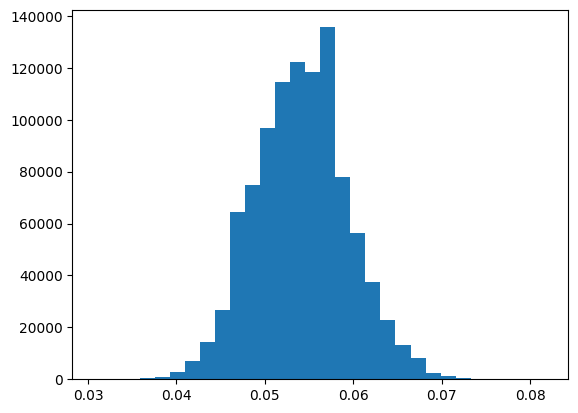

Mean:  0.054191396010702296
Confidence interval:  [0.04391329 0.06488864]


In [28]:
plt.hist(f1scores, bins = 30)
plt.show()
print("Mean: ", mean(f1scores))
conf_interval_f1score = np.percentile(f1scores,[2.5,97.5])
print("Confidence interval: ",conf_interval_f1score)

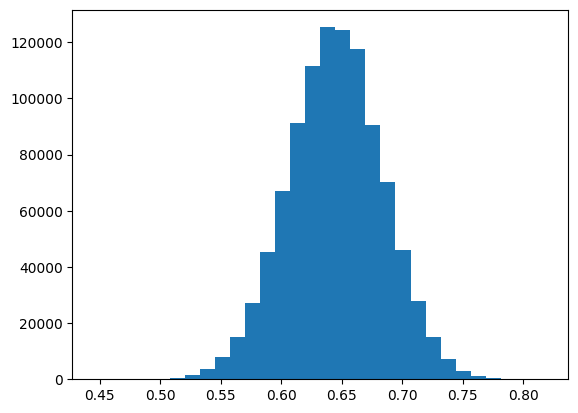

Mean:  0.644868702883293
Confidence interval:  [0.56756757 0.72049689]


In [29]:
plt.hist(recalls, bins = 30)
plt.show()
print("Mean: ", mean(recalls))
conf_interval_recall = np.percentile(recalls,[2.5,97.5])
print("Confidence interval: ",conf_interval_recall)

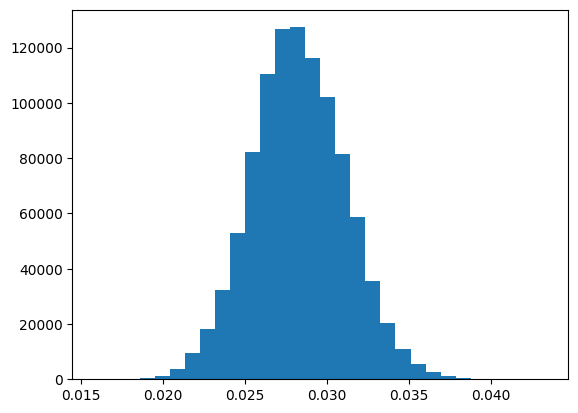

Mean:  0.028291841908045585
Confidence interval:  [0.02285218 0.03396661]


In [30]:
plt.hist(precisions, bins = 30)
plt.show()
print("Mean: ", mean(precisions))
conf_interval_precision = np.percentile(precisions,[2.5,97.5])
print("Confidence interval: ",conf_interval_precision)

In [31]:
final_df.loc[~final_df.apply(lambda row: check_good_measure(row["found"], row["gold_found"]), axis=1)]

,term,full_term,source,span_converted,label,found,gold_label,gold_found
0,créatininémie,créatininémie à 77 umol/l,CRH_1969733462691716259.ann,"[4176, 4189]",{C0201975},[77.0 nounit],{},[]
1,Glucose à jeun,Glucose à jeun ¦mmol/L ¦5.8 + ¦3.9-5.6,CRH_1969733462691716259.ann,"[16227, 16241]",{C0428568},[5.8 mmol_per_l],{},[]
2,Glucose à jeun,Glucose à jeun ¦g/L ¦1.05 + ¦0.70-1.00,CRH_1969733462691716259.ann,"[16266, 16280]",{C0428568},[1.05 g_per_l],{},[]
3,Sodium,Sodium ¦mmol/L ¦141 ¦136-146,CRH_1969733462691716259.ann,"[16448, 16454]",{C0337443},[141.0 mmol_per_l],{},[]
4,Potassium,Potassium ¦mmol/L ¦4.0 ¦3.5-4.5,CRH_1969733462691716259.ann,"[16477, 16486]",{C0202194},[4.0 mmol_per_l],{},[]
...,...,...,...,...,...,...,...,...
3460,CO2 total,CO2 total ¦mmol/L ¦25.7,CRH_8113406945803901659.ann,"[5934, 5943]",{C0201930},[25.7 mmol_per_l],{},[]
3461,Bicarbonate,Bicarbonate ¦mmol/L ¦24.6,CRH_8113406945803901659.ann,"[5958, 5969]",{C0202059},[24.6 mmol_per_l],{},[]
3462,SatO2,SatO2 ¦% ¦99.1,CRH_8113406945803901659.ann,"[5984, 5989]",{C0428179},[99.1 percent],{},[]
3463,Excès de base,Excès de base ¦mmol/L ¦1.2,CRH_8113406945803901659.ann,"[5999, 6012]",{C0201985},[1.2 mmol_per_l],{},[]
